# Preprocessing the Dataset

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

Importing all required packages

In [2]:
import pandas as pd
import sys
import pickle

sys.path.append('./')
import utils

from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss

In [3]:
seed = 42

## Loading Rogue Wave Data

Note:

- The data are stored in a csv file of the size 1048574 x 29.
- Modified ina's input dataset, now the encoded values as well as original wave dir and obj weather data are in a same file

In [ ]:
data_rogue_waves = pd.read_csv("../data/ML_Matrix_full_encoded_st.csv", index_col=0)

In [5]:
print(f"The dataset has {data_rogue_waves.shape[1] - 1} variables that describe {data_rogue_waves.shape[0]} waves.")

The dataset has 17 variables that describe 53490 waves.


In [6]:
data_rogue_waves.head()

,H_s,lambda_40,lambda_30,L_deep,s,mu,kh,T_p,eps,nu,Q_p,swell,v_wind,T_air,Delta_T,p,Delta_p_1h,AI_10min
0,0.98,0.117,0.026,24.74,0.040,0.5,6.731,2.51,0.802,0.496,1.598,0.095,8.97,7.0,0.0,1012.64,-0.3,1.49
1,0.99,0.101,0.039,24.76,0.040,0.5,6.725,2.51,0.802,0.495,1.623,0.094,8.97,7.0,0.0,1012.64,-0.3,1.49
2,1.64,0.033,0.087,36.17,0.045,0.5,4.603,2.92,0.764,0.356,3.465,0.005,12.21,3.7,0.1,1003.34,2.1,1.48
3,0.81,-0.026,0.022,22.52,0.036,0.5,7.394,3.54,0.788,0.490,1.502,0.041,7.75,2.5,0.1,1016.64,0.2,1.47
4,0.79,0.202,0.158,20.99,0.038,0.5,7.934,4.00,0.793,0.513,1.324,0.027,8.49,3.5,-0.3,1017.34,0.1,1.49


### Preprocessing

Some of the target values are close to 3, which is not realistic, hence, they are excluded from the dataset.

In [7]:
thr_target = 2.7
data_rogue_waves = data_rogue_waves.loc[data_rogue_waves.AI_10min < thr_target]

Select key features

In [8]:
target = 'AI_10min'
target_cat = 'AI_10min_cat'
features = ['H_s', 'lambda_40', 'lambda_30', 'L_deep', 's', 'mu', 'kh', 'T_p', 'eps', 'nu', 'Q_p', 'swell', 'v_wind', 'T_air', 'Delta_T', 'p', 'Delta_p_1h']
data_rogue_waves = data_rogue_waves.loc[:,[target]+features]

In [9]:
data_rogue_waves

,AI_10min,H_s,lambda_40,lambda_30,L_deep,s,mu,kh,T_p,eps,nu,Q_p,swell,v_wind,T_air,Delta_T,p,Delta_p_1h
0,1.49,0.98,0.117,0.026,24.74,0.040,0.50,6.731,2.51,0.802,0.496,1.598,0.095,8.97,7.0,0.0,1012.64,-0.3
1,1.49,0.99,0.101,0.039,24.76,0.040,0.50,6.725,2.51,0.802,0.495,1.623,0.094,8.97,7.0,0.0,1012.64,-0.3
2,1.48,1.64,0.033,0.087,36.17,0.045,0.50,4.603,2.92,0.764,0.356,3.465,0.005,12.21,3.7,0.1,1003.34,2.1
3,1.47,0.81,-0.026,0.022,22.52,0.036,0.50,7.394,3.54,0.788,0.490,1.502,0.041,7.75,2.5,0.1,1016.64,0.2
4,1.49,0.79,0.202,0.158,20.99,0.038,0.50,7.934,4.00,0.793,0.513,1.324,0.027,8.49,3.5,-0.3,1017.34,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53485,2.09,0.99,-0.006,0.021,33.23,0.030,0.51,5.011,3.88,0.838,0.496,2.050,0.026,8.78,3.2,0.4,1011.44,0.0
53486,2.10,1.10,0.402,0.195,21.55,0.051,0.51,7.726,2.65,0.783,0.442,2.019,0.024,13.13,5.8,-0.3,1009.44,-0.2
53487,2.12,0.61,0.331,0.209,18.02,0.034,0.51,9.238,1.75,0.781,0.470,1.691,0.038,7.85,6.9,-0.1,1018.74,-0.2
53488,2.00,1.15,0.041,0.053,43.71,0.026,0.49,3.809,3.83,0.852,0.505,2.140,0.057,6.20,-0.8,-0.2,1008.84,0.2


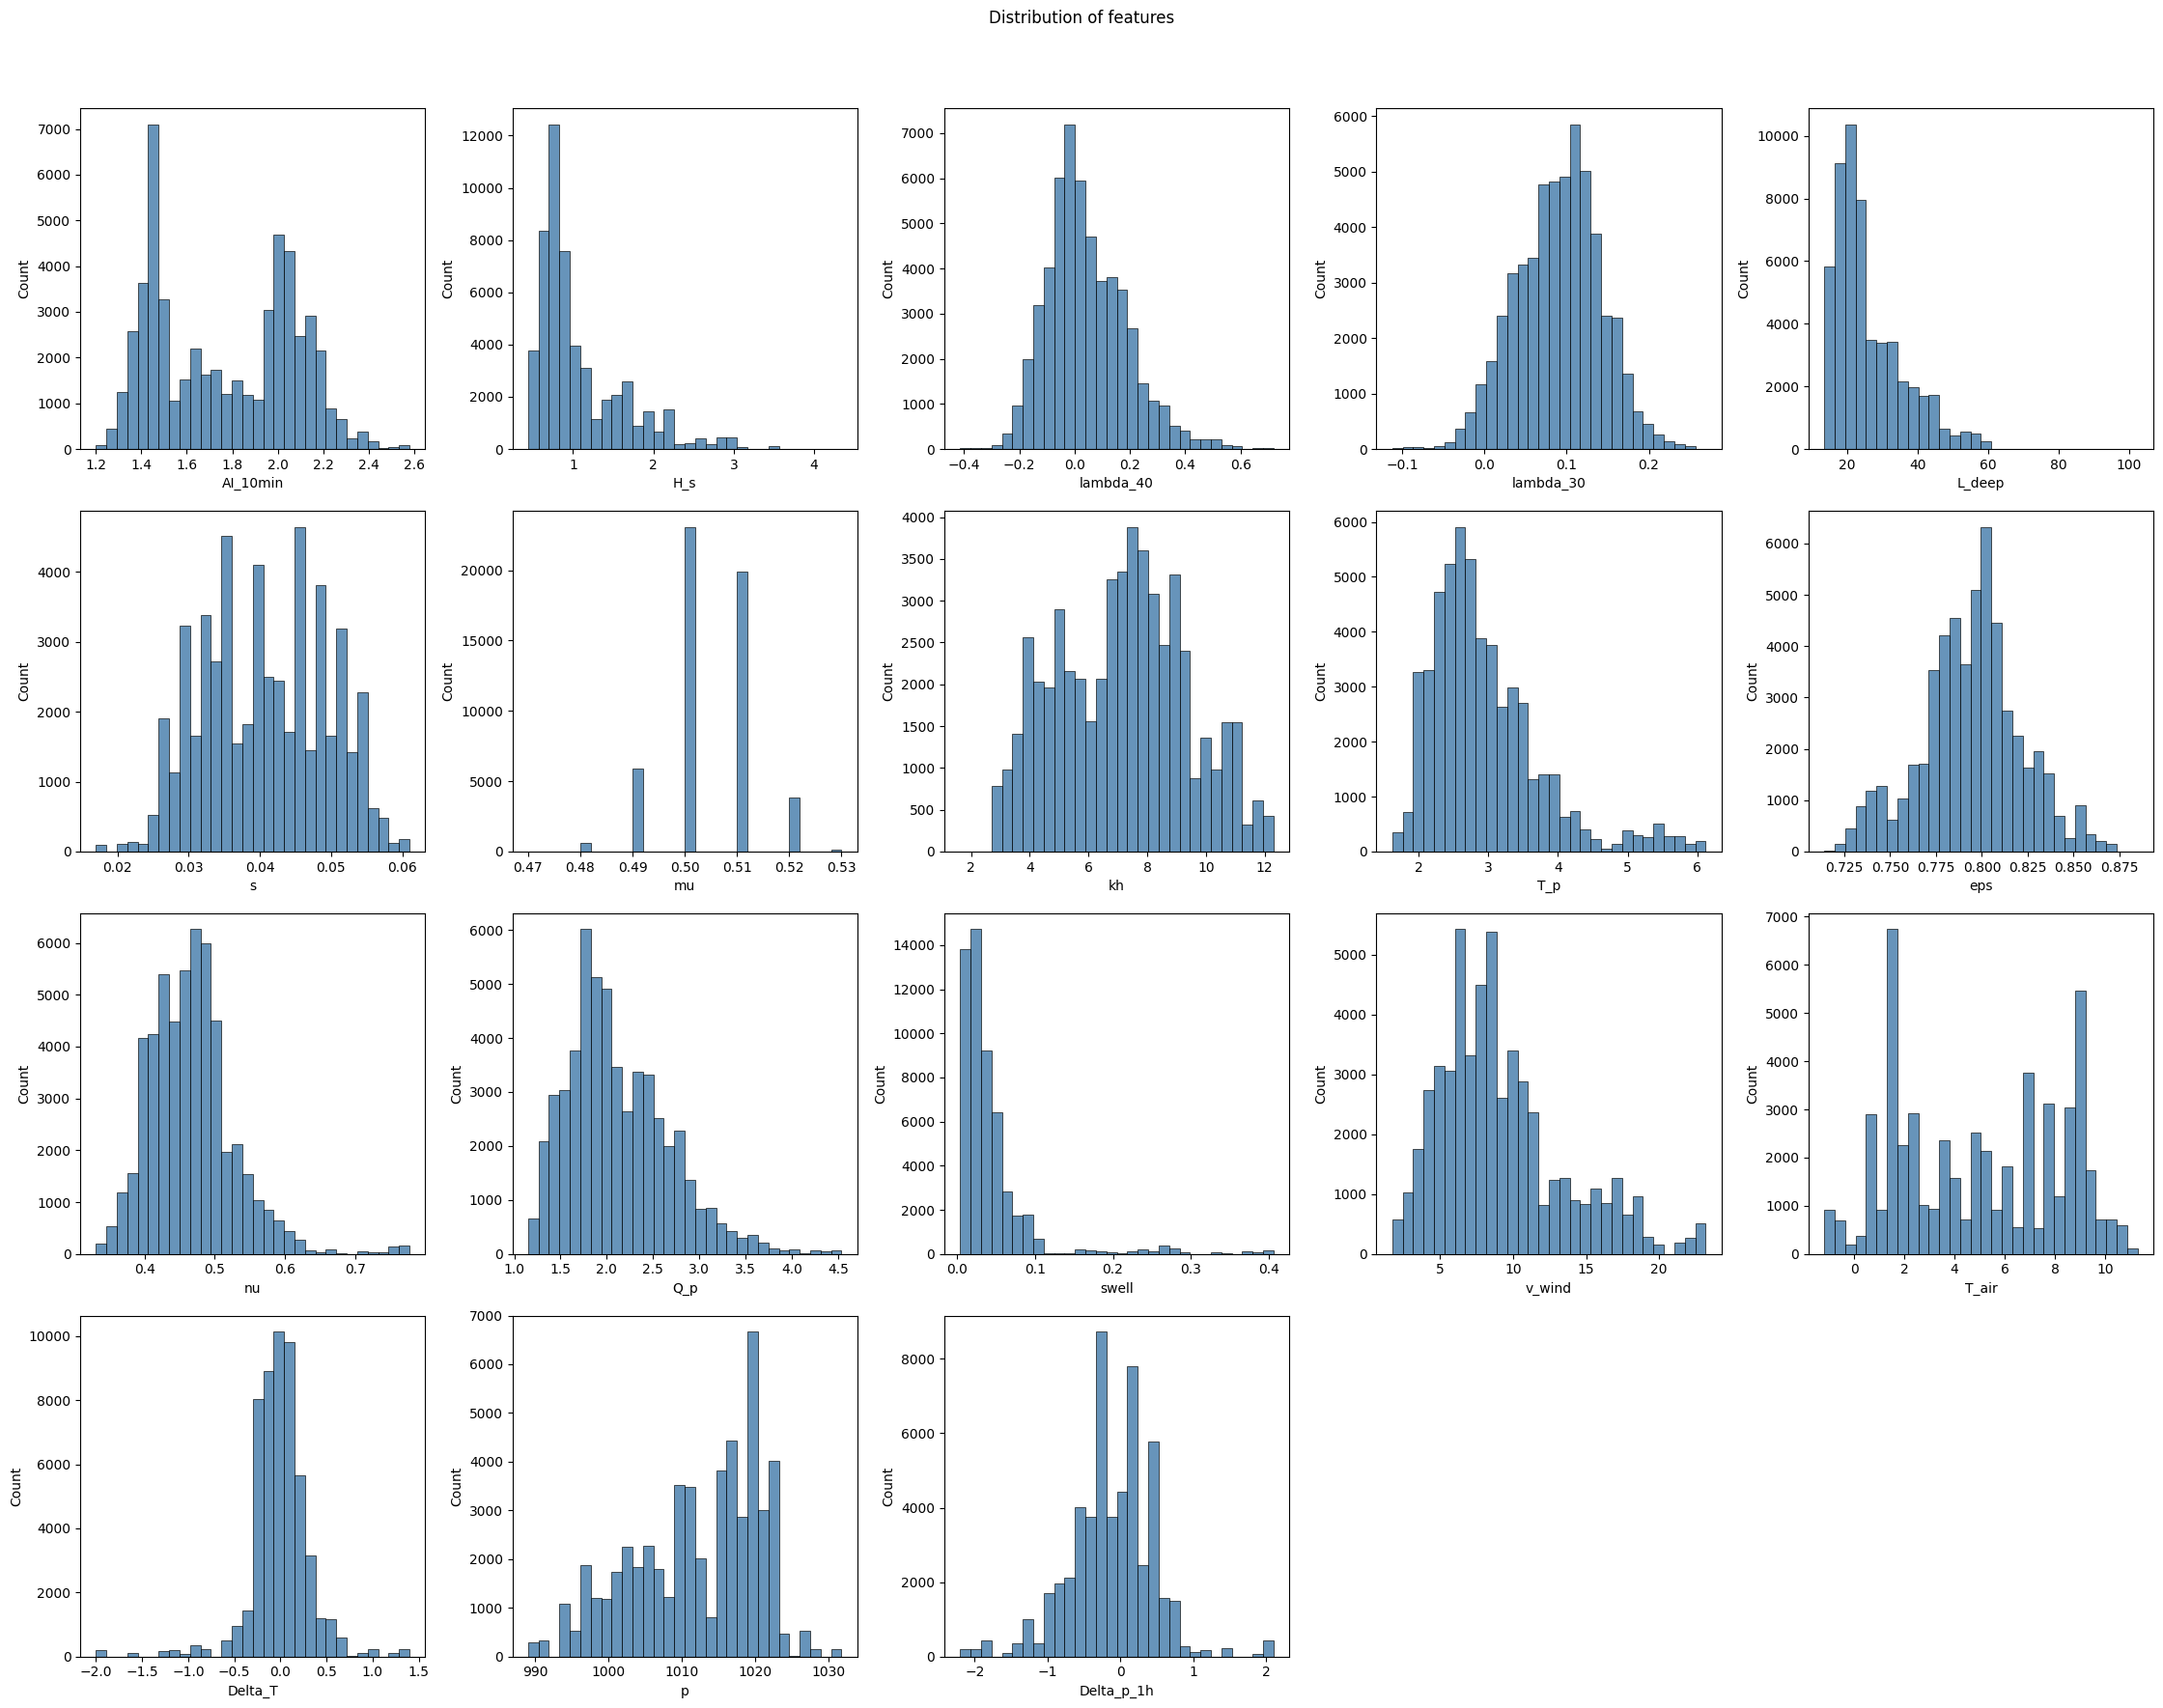

In [10]:
utils.plot_distributions(dataset=data_rogue_waves, ncols=5)

For classification approach, we need to turn the target values into classes.  
We will have a look at three different target transformations:

- case 1: class 0: target < 2.0 and class 1: target > 2.0 
- case 2: class 0: target < 1.5 and class 1: target > 2.0
- case 3: class 0: target < 1.5, class 1: 1.5 < target < 2.0 and class 2: target > 2.0

**Case 1:**

In [11]:
# Define the threshold
threshold = 2.0

# Binarize target 
data_rogue_waves_case1 = data_rogue_waves.copy()
data_rogue_waves_case1[target_cat] = data_rogue_waves_case1[target].apply(lambda x: 0 if x < threshold else 1)
data_rogue_waves_case1[target_cat] = data_rogue_waves_case1[target_cat].astype(int)

print('Dataset target distribution:')
print(Counter(data_rogue_waves_case1[target_cat]))

Dataset target distribution:
Counter({0: 35660, 1: 17830})


**Case 2:**

In [12]:
# Define thresholds for three classes
threshold_1 = 1.5
threshold_2 = 2.0

# Binarize target 
data_rogue_waves_case2 = data_rogue_waves.copy()
data_rogue_waves_case2[target_cat] = data_rogue_waves_case2[target].apply(lambda x: 0 if x < threshold_1 else (0.5 if x < threshold_2 else 1))
data_rogue_waves_case2 = data_rogue_waves_case2[data_rogue_waves_case2[target_cat].isin([0, 1])]
data_rogue_waves_case2[target_cat] = data_rogue_waves_case2[target_cat].astype(int)

print('Dataset target distribution:')
print(Counter(data_rogue_waves_case2[target_cat]))

Dataset target distribution:
Counter({0: 17830, 1: 17830})


**Case 3:**

In [13]:
# Define thresholds for three classes
threshold_1 = 1.5
threshold_2 = 2.0

# Binarize target 
data_rogue_waves_case3 = data_rogue_waves.copy()
data_rogue_waves_case3[target_cat] = data_rogue_waves_case3[target].apply(lambda x: 0 if x < threshold_1 else (1 if x < threshold_2 else 2))
data_rogue_waves_case3[target_cat] = data_rogue_waves_case3[target_cat].astype(int)

print('Dataset target distribution:')
print(Counter(data_rogue_waves_case3[target_cat]))

Dataset target distribution:
Counter({0: 17830, 1: 17830, 2: 17830})


### Setup train and test data

Split data into train and test dataset with stratified split, to ensure having enough instances of the minority class in both train and test set. Then save the dataset to pickl.

To tackle the high class imbalance we will undersample the larger class using NearMiss Undersampler. Near-miss is an algorithm that can help in balancing an imbalanced dataset. It can be grouped under undersampling algorithms and is an efficient way to balance the data. The algorithm does this by looking at the class distribution and randomly eliminating samples from the larger class. When two points belonging to different classes are very close to each other in the distribution, this algorithm eliminates the datapoint of the larger class thereby trying to balance the distribution.

For expl of version argument and n_neighbours see https://hersanyagci.medium.com/under-sampling-methods-for-imbalanced-data-clustercentroids-randomundersampler-nearmiss-eae0eadcc145

In [14]:
for i, data in enumerate([data_rogue_waves_case1, data_rogue_waves_case2, data_rogue_waves_case3]):

    print(f"\nProcess data for case {i}")

    # split into train and test data
    data_train, data_test = train_test_split(data, stratify=data[target_cat], train_size=0.80, random_state=seed)

    data_train.reset_index(inplace=True, drop=True)
    data_test.reset_index(inplace=True, drop=True)

    print('Training dataset target distribution:')
    print(Counter(data_train[target_cat]))

    print('Test dataset target distribution:')
    print(Counter(data_test[target_cat]))

    # Save the data 
    data = [data_train, data_test]

    with open(f'../data/data_case{i+1}.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Undersample the larger class
    X_train = data_train[features+[target]]
    y_train = data_train[target_cat]
    nm = NearMiss(version=1, sampling_strategy='auto', n_neighbors=5) 
    X_train, y_train = nm.fit_resample(X_train, y_train)    

    print('Resampled dataset shape:')
    print(Counter(y_train))

    # After undersampling, drop the continuous target variable from the dataset as we only use the binarized version for classification.
    data_train = X_train
    data_train[target_cat] = y_train

    data = [data_train, data_test]

    # Save the data 
    with open(f'../data/data_case{i+1}_undersampled.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


Process data for case 0
Training dataset target distribution:
Counter({0: 28528, 1: 14264})
Test dataset target distribution:
Counter({0: 7132, 1: 3566})
Resampled dataset shape:
Counter({0: 14264, 1: 14264})

Process data for case 1
Training dataset target distribution:
Counter({1: 14264, 0: 14264})
Test dataset target distribution:
Counter({0: 3566, 1: 3566})
Resampled dataset shape:
Counter({0: 14264, 1: 14264})

Process data for case 2
Training dataset target distribution:
Counter({1: 14264, 2: 14264, 0: 14264})
Test dataset target distribution:
Counter({2: 3566, 1: 3566, 0: 3566})
Resampled dataset shape:
Counter({0: 14264, 1: 14264, 2: 14264})
